<a href="https://colab.research.google.com/github/jeonghoya/Machine-Learning-Programming/blob/main/week11/AE_creditcard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# PyTorch 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [4]:
# 1. 데이터 로드 및 전처리
# 신용카드 데이터셋을 불러옵니다.
# 원본 파일 경로 'E:/dataset/creditcard.csv'를 현재 디렉토리의 'creditcard.csv'로 변경합니다.
# 파일이 다른 위치에 있다면 경로를 수정해주세요.
try:
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/creditcard.csv')
except FileNotFoundError:
    print("경고: 'creditcard.csv' 파일을 찾을 수 없습니다.")
    print("Kaggle에서 'Credit Card Fraud Detection' 데이터셋을 다운로드 받아 같은 디렉토리에 저장해주세요.")
    # 예시로 빈 데이터프레임을 생성하여 이후 셀이 오류 없이 실행되도록 합니다.
    # 실제 분석을 위해서는 데이터 파일이 필요합니다.
    df = pd.DataFrame()

#
if not df.empty:
    # display(df.head()) # .py 파일에서는 display 대신 print를 사용하거나 생략합니다.
    print(df.head())

#
if not df.empty:
    print(df.shape)

#
# 결측치 홗인
if not df.empty:
    print(df.isnull().values.any())

#
LABELS = ["Normal", "Fraud"]

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

/tmp/ipython-input-937628991.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


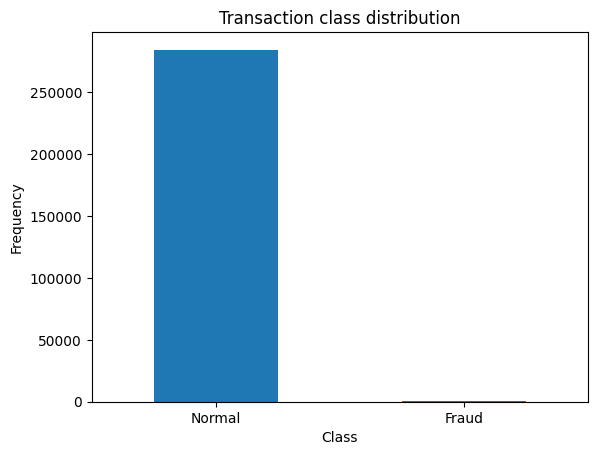

Frauds shape: (492, 31)
Normal shape: (284315, 31)
Normal shape (check): (284315, 31)


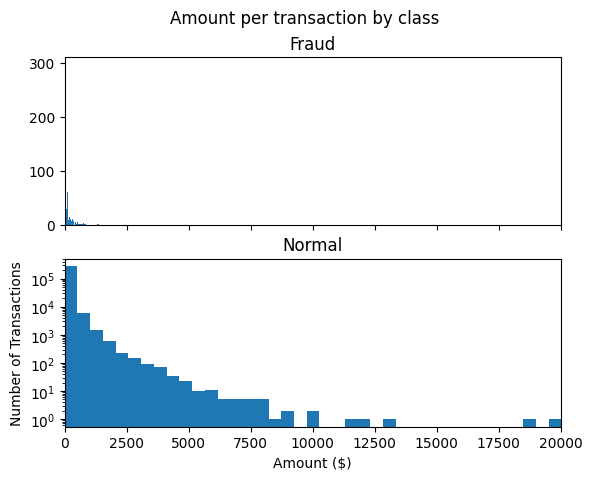

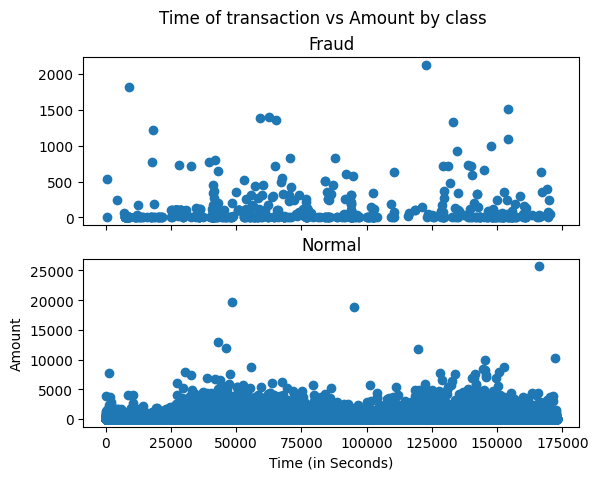

In [5]:
#
if not df.empty:
    count_classes = pd.value_counts(df['Class'], sort = True)
    count_classes.plot(kind = 'bar', rot=0)
    plt.title("Transaction class distribution")
    plt.xticks(range(2), LABELS)
    plt.xlabel("Class")
    plt.ylabel("Frequency");
    plt.show() # .py 파일에서는 plt.show()를 명시적으로 호출합니다.
else:
    print("데이터프레임이 비어있어 플롯을 생성할 수 없습니다.")

#
if not df.empty:
    frauds = df[df.Class == 1]
    normal = df[df.Class == 0]
    print(f"Frauds shape: {frauds.shape}")
    print(f"Normal shape: {normal.shape}")

#
# (셀 8에서 이미 출력되므로 중복이지만 구조 유지를 위해 남겨둡니다)
if not df.empty:
    print(f"Normal shape (check): {normal.shape}")

#
if not df.empty:
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    f.suptitle('Amount per transaction by class')

    bins = 50

    ax1.hist(frauds.Amount, bins = bins)
    ax1.set_title('Fraud')

    ax2.hist(normal.Amount, bins = bins)
    ax2.set_title('Normal')

    plt.xlabel('Amount ($)')
    plt.ylabel('Number of Transactions')
    plt.xlim((0, 20000))
    plt.yscale('log')
    plt.show();
else:
    print("데이터프레임이 비어있어 플롯을 생성할 수 없습니다.")

#
if not df.empty:
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    f.suptitle('Time of transaction vs Amount by class')

    ax1.scatter(frauds.Time, frauds.Amount)
    ax1.set_title('Fraud')

    ax2.scatter(normal.Time, normal.Amount)
    ax2.set_title('Normal')

    plt.xlabel('Time (in Seconds)')
    plt.ylabel('Amount')
    plt.show()
else:
    print("데이터프레임이 비어있어 플롯을 생성할 수 없습니다.")

#
if not df.empty:
    data = df.drop(['Time'], axis=1)

    data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
else:
    print("데이터프레임이 비어있어 전처리를 건너뜁니다.")

#
# 모델을 오직 정상 거래기록으로만 훈련
# 정상 거래기록을 테스트셋에 넣으면 모델의 성능을 평가

#
RANDOM_SEED = 42

In [6]:
#
if not df.empty:
    # Keras와 동일한 분할
    X_train_df, X_test_df = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
    X_train_df = X_train_df[X_train_df.Class == 0]
    X_train_df = X_train_df.drop(['Class'], axis=1)

    y_test_series = X_test_df['Class']
    X_test_df = X_test_df.drop(['Class'], axis=1)

    print(f"X_train_df (정상) shape: {X_train_df.shape}")

    # PyTorch를 위한 Tensor 변환
    # Keras의 validation_split=0.1을 재현하기 위해 train_data를 다시 분할
    X_train_tensor = torch.tensor(X_train_df.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_df.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_series.values, dtype=torch.float32)

    # 훈련 데이터(X_train_tensor)를 다시 훈련셋과 검증셋으로 분할 (9:1)
    train_data, val_data = train_test_split(X_train_tensor, test_size=0.1, random_state=RANDOM_SEED)

    print(f"Train data shape: {train_data.shape}")
    print(f"Validation data shape: {val_data.shape}")
    print(f"Test data shape: {X_test_tensor.shape}")

    # DataLoader 생성
    batch_size = 256
    # 오토인코더이므로 입력과 타겟이 동일 (train_data, train_data)
    train_dataset = TensorDataset(train_data, train_data)
    val_dataset = TensorDataset(val_data, val_data)
    # 테스트셋은 피처(X_test_tensor)와 실제 레이블(y_test_tensor)을 가짐
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # GPU 사용 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
else:
    print("데이터프레임이 비어있어 텐서 변환을 건너뜁니다.")
    # 이후 셀에서 오류가 나지 않도록 빈 변수/객체 생성
    df = pd.DataFrame()
    X_train_df = pd.DataFrame()
    y_test_series = pd.Series()
    device = torch.device("cpu")

# 테스트 레이블을 남겨두는 이유는 나중에 정확도를 비교하기 위해서임

X_train_df (정상) shape: (227451, 29)
Train data shape: torch.Size([204705, 29])
Validation data shape: torch.Size([22746, 29])
Test data shape: torch.Size([56962, 29])
Using device: cuda


In [7]:
# 오토인코더 모델 (PyTorch)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()

        # Keras 모델과 동일한 구조: 29 -> 14 -> 7
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(),
            nn.Linear(encoding_dim, int(encoding_dim / 2)),
            nn.ReLU()
        )

        # Keras 모델과 동일한 구조: 7 -> 7 -> 29
        self.decoder = nn.Sequential(
            nn.Linear(int(encoding_dim / 2), int(encoding_dim / 2)),
            nn.ReLU(),
            nn.Linear(int(encoding_dim / 2), input_dim),
            nn.Sigmoid()  # Keras와 동일하게 Sigmoid 사용
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
if not df.empty:
    # 모델 인스턴스화
    input_dim = X_train_df.shape[1] # 29
    encoding_dim = 14

    model = Autoencoder(input_dim, encoding_dim).to(device)

    # 손실 함수 및 옵티마이저
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(model)
else:
    print("데이터가 없어 모델을 초기화하지 않습니다.")

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=29, out_features=14, bias=True)
    (1): ReLU()
    (2): Linear(in_features=14, out_features=7, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=7, out_features=7, bias=True)
    (1): ReLU()
    (2): Linear(in_features=7, out_features=29, bias=True)
    (3): Sigmoid()
  )
)


Epoch 1/50 - loss: 1.0239 - val_loss: 0.9915
Epoch 2/50 - loss: 0.9185 - val_loss: 0.9561
Epoch 3/50 - loss: 0.8967 - val_loss: 0.9452
Epoch 4/50 - loss: 0.8879 - val_loss: 0.9396
Epoch 5/50 - loss: 0.8840 - val_loss: 0.9359
Epoch 6/50 - loss: 0.8809 - val_loss: 0.9329
Epoch 7/50 - loss: 0.8771 - val_loss: 0.9276
Epoch 8/50 - loss: 0.8706 - val_loss: 0.9219
Epoch 9/50 - loss: 0.8665 - val_loss: 0.9191
Epoch 10/50 - loss: 0.8644 - val_loss: 0.9174
Epoch 11/50 - loss: 0.8626 - val_loss: 0.9155
Epoch 12/50 - loss: 0.8609 - val_loss: 0.9142
Epoch 13/50 - loss: 0.8600 - val_loss: 0.9134
Epoch 14/50 - loss: 0.8593 - val_loss: 0.9128
Epoch 15/50 - loss: 0.8587 - val_loss: 0.9123
Epoch 16/50 - loss: 0.8583 - val_loss: 0.9118
Epoch 17/50 - loss: 0.8579 - val_loss: 0.9120
Epoch 18/50 - loss: 0.8575 - val_loss: 0.9112
Epoch 19/50 - loss: 0.8572 - val_loss: 0.9110
Epoch 20/50 - loss: 0.8569 - val_loss: 0.9108
Epoch 21/50 - loss: 0.8567 - val_loss: 0.9106
Epoch 22/50 - loss: 0.8565 - val_loss: 0.91

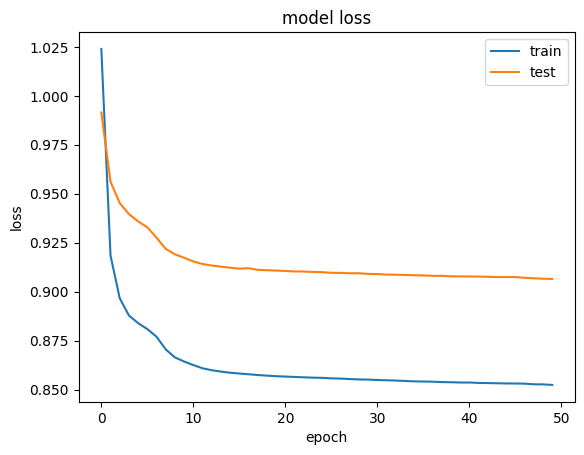

In [9]:
# 3. 모델 학습 (PyTorch)
num_epochs = 50
history = {'train_loss': [], 'val_loss': []}

if not df.empty:
    for epoch in range(num_epochs):
        # --- 훈련 단계 ---
        model.train() # 모델을 훈련 모드로 설정
        running_train_loss = 0.0
        for inputs, _ in train_loader: # 오토인코더이므로 레이블은 무시
            inputs = inputs.to(device)

            # 옵티마이저 초기화
            optimizer.zero_grad()

            # 순전파
            outputs = model(inputs)
            loss = criterion(outputs, inputs) # 입력 자신을 타겟으로 손실 계산

            # 역전파 및 최적화
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)

        # --- 검증 단계 ---
        model.eval() # 모델을 평가 모드로 설정
        running_val_loss = 0.0
        with torch.no_grad(): # 기울기 계산 비활성화
            for inputs, _ in val_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                running_val_loss += loss.item() * inputs.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        history['val_loss'].append(epoch_val_loss)

        if (epoch + 1) % 1 == 0: # 1 에포크마다 출력 (Keras와 유사하게)
            print(f"Epoch {epoch+1}/{num_epochs} - loss: {epoch_train_loss:.4f} - val_loss: {epoch_val_loss:.4f}")
else:
    print("데이터가 없어 모델 훈련을 건너뜁니다.")

#
if not df.empty:
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right');
    plt.show()
else:
    print("훈련 기록이 없어 손실 플롯을 생성할 수 없습니다.")

In [10]:
# X_test 값을 넣어서 Reconstruction Error 값을 얻고,
# 실제 레이블인 y_test와 데이터프레임으로 구성
# Reconstruction Error + 실제 레이블의 형태가 됨

if not df.empty:
    model.eval() # 평가 모드
    reconstruction_errors = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            # Keras의 `np.mean(np.power(X_test - predictions, 2), axis=1)`와 동일
            mse = torch.mean(torch.pow(inputs - outputs, 2), dim=1)

            reconstruction_errors.extend(mse.cpu().numpy())
            true_labels.extend(labels.cpu().numpy()) # labels는 이미 1D

    # 원본 Keras 코드와 동일하게 y_test_series의 인덱스를 사용
    error_df = pd.DataFrame(
        {'reconstruction_error': reconstruction_errors,
         'true_class': y_test_series.values},
        index=y_test_series.index
    )
    print(error_df.describe())
else:
    print("데이터가 없어 예측 및 오류 계산을 건너뜁니다.")

# %%
if not df.empty:
    print(error_df.head())
else:
    print("error_df가 생성되지 않았습니다.")

       reconstruction_error    true_class
count          56962.000000  56962.000000
mean               0.885180      0.001720
std                3.752745      0.041443
min                0.049371      0.000000
25%                0.267821      0.000000
50%                0.455903      0.000000
75%                0.744421      0.000000
max              260.161438      1.000000
        reconstruction_error  true_class
43428              82.185379           1
49906               0.974240           0
29474               0.394731           0
276481              0.372327           0
278846              0.199496           0


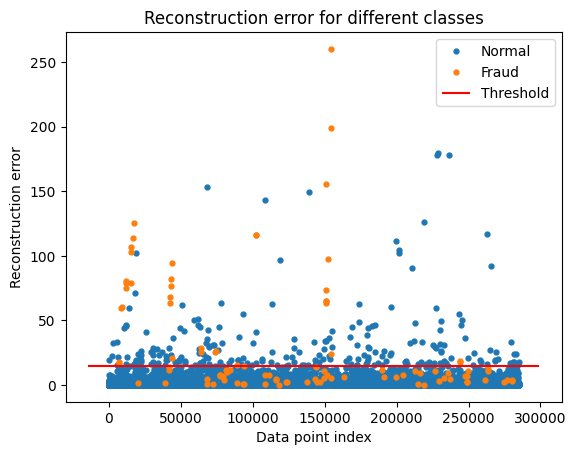

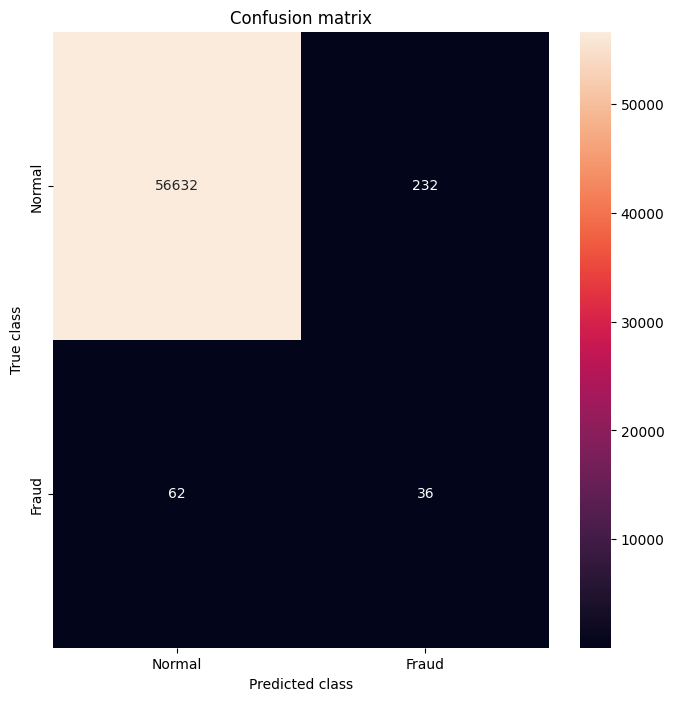

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.13      0.37      0.20        98

    accuracy                           0.99     56962
   macro avg       0.57      0.68      0.60     56962
weighted avg       1.00      0.99      1.00     56962



In [11]:
# threshold 값을 조정하여 최선의 정확도를 얻음, 그래프로를 보고 결정

threshold = 15

# %%
if not df.empty:
    groups = error_df.groupby('true_class')
    fig, ax = plt.subplots()

    for name, group in groups:
        ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
                label= "Fraud" if name == 1 else "Normal")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for different classes")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.show();
else:
    print("error_df가 생성되지 않아 플롯을 그릴 수 없습니다.")

# %%
if not df.empty:
    y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
    conf_matrix = confusion_matrix(error_df.true_class, y_pred)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

    print(classification_report(error_df.true_class, y_pred))
else:
    print("error_df가 생성되지 않아 Confusion Matrix를 생성할 수 없습니다.")